In [1]:
import warnings
warnings.filterwarnings("ignore")
import sys
sys.argv=['SAGP.py','test.txt','test.info','test.out']
import matplotlib
#matplotlib.use('Agg')
###We checked and print the arguments

print('Number of arguments:', str(len(sys.argv)), 'arguments.')
if len(sys.argv)<3:
    print("""
    ### usage: python SAGP.py [datafile] [setupfile] [outputfile] [newlocations]
    ### example: python SAGP.py dummy.txt dummy.info dummy.out
    ###[datafile] The dataset you want to analyze. The columns of the txt file are dimensions/variables; the columns of the txt file are samples.
    ####The first column of the datafile is considered Y (response) and the rest columns are considered X (inputs).
    ###[setupfile] The setup files including 
    ###[outputfile] (optional) The file name you want to store the posterior samples of SAGP model.
    ###[newlocations] (optional) The dataset of locations for which we want to predict. If not provided, the predictions will be done at the original locations cotained in [datafile].
    ###Functionality of this code.
    ###Read in the data file and output the SAGP fit with parameters in setup file.""")
    sys.exit()
print('Argument List:', str(sys.argv),'\n')
datafile=sys.argv[1]
print('Data file:', datafile)
setupfile=sys.argv[2]
print('Setup file:', setupfile)

if len(sys.argv)>=3:
    outputfile=sys.argv[3]
else:
    outputfile=datafile+'.out'

meanfile=outputfile+'.mean'
pdffile=outputfile+'.pdf'
print('Output file:', outputfile)
print('PDF output',pdffile)

import numpy as np
stepl = 0.02
x = np.arange(0, 1+stepl, stepl)
y = np.arange(0, 1+stepl, stepl)
xx, yy = np.meshgrid(x, y, sparse=False)
tt = np.asarray(np.hstack((xx.reshape(-1,1),yy.reshape(-1,1))))
np.shape(tt)
print(tt)

Number of arguments: 4 arguments.
Argument List: ['SAGP.py', 'test.txt', 'test.info', 'test.out'] 

Data file: test.txt
Setup file: test.info
Output file: test.out
PDF output test.out.pdf
[[0.   0.  ]
 [0.02 0.  ]
 [0.04 0.  ]
 ...
 [0.96 1.  ]
 [0.98 1.  ]
 [1.   1.  ]]


In [2]:
def generateTree(L=2,D=2):
    VERBOSE=False
    tinfo = [None]*L
    for l in range(L):
        loc_temp = np.linspace(start=0, stop=1, num=1+2**(l+1))[1:-1]
        if VERBOSE:print(l,loc_temp)
        loc_d = loc_temp[np.arange(start=0,stop=len(loc_temp),step=2)]
        if VERBOSE:print(l,loc_d)
        mesh_d = np.meshgrid(*[loc_d]*D)
        if VERBOSE:print(l,np.asarray(mesh_d).reshape(-1,D).shape)
        tmp_arr=np.asarray(mesh_d).T.reshape(-1,D)
        if VERBOSE:print(tmp_arr)
        tinfo[l]=np.vstack( ( tmp_arr, tmp_arr ) )
        if VERBOSE:print(l,tinfo[l])
        for k in range(2*tmp_arr.shape[0]):
            if np.mod(k,2)==1: 
                tinfo[l][k,:]=[1/2**(l+1)]*D
            else:
                tinfo[l][k,:]=tmp_arr[int(k/2),:]
        if VERBOSE:print(l,tinfo[l])
    return(tinfo)
generateTree(2,2)

[array([[0.5, 0.5],
        [0.5, 0.5]]),
 array([[0.25, 0.25],
        [0.25, 0.25],
        [0.25, 0.75],
        [0.25, 0.25],
        [0.75, 0.25],
        [0.25, 0.25],
        [0.75, 0.75],
        [0.25, 0.25]])]

X shape (441, 2)
Xnew shape (2601, 2)
Number of input locations: 441
Number of predictive locations: 441
Total number of steps: 13


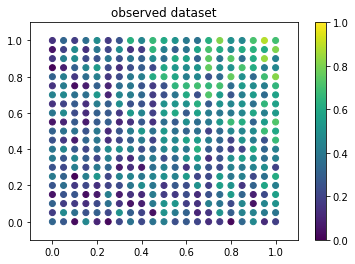

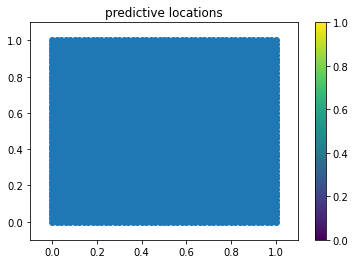

In [3]:
#Preparing toy dataset, for simplicity we set X to be in [0.1]^2 and avoid standardization of X.
dataset = np.loadtxt(datafile)
#print(dataset)
#Y = np.array([1, 2, 3, 4, 5, 2.5, 6.5, 2.141])
#X = np.array([[0.55, 0.55],
#              [0.25, 0.30],
#              [0.77, 0.25],
#              [0.26, 0.76],
#              [0.67, 0.33],
#              [0.22, 0.89],
#              [0.34, 0.56],
#              [0.51, 0.77]])
X = dataset[:,1:np.shape(dataset)[1]]
#Y = dataset[:,0]
Y = np.random.uniform(low=0,high=0.5,size=441)+X[:,0]*0.5*np.sin(X[:,1])
#Plot the dataset to illustrate the data.
import matplotlib.pyplot as plt
plt.figure(0)
plt.scatter(X[:,0],X[:,1], c=Y, cmap='viridis',vmin=0,vmax=1)
plt.xlim(xmax = 1.1, xmin = -0.1)
plt.ylim(ymax = 1.1, ymin = -0.1)
plt.colorbar()
plt.title('observed dataset')

#Set the predictive locations
if len(sys.argv)>=5:
    Xnew = np.loadtxt(sys.argv[4])
else:
    Xnew = X
#Xnew = np.array([[0.50, 0.50],
#                [0.25, 0.80],
#                [0.75, 0.25],
#                [0.25, 0.75],
#                [0.50, 0.95],
#                [0.30, 0.80],
#                [0.90, 0.50],
#                [0.80, 0.25]])
Xnew = tt
print('X shape',np.shape(X))
print('Xnew shape',np.shape(Xnew))

plt.figure(1)
plt.scatter(Xnew[:,0],Xnew[:,1],vmin=0,vmax=1)
plt.xlim(xmax = 1.1, xmin = -0.1)
plt.ylim(ymax = 1.1, ymin = -0.1)
plt.colorbar()
plt.title('predictive locations')


#Preparing model parameters and a fixed 2-layer binary tree on [0,1]^2 for illustration purpose.
pinfo = {'m': 5, 
         'a':100, 'b':1,
         'logRhoFirstLayer':1,'logRhoLastLayer':50,
         'r':0.1}
minfo = {'seed': 123, 
         'Nmcmc': 10, 'burnIn': 3, 
         'semiWidthRho':0.05,'semiWidthEta':0.05}
#tinfo = [np.array([[0.50,0.50],[0.50,0.50]]),
#         np.array([[0.25,0.25],[0.25,0.25],
#                   [0.25,0.75],[0.25,0.25],
#                   [0.75,0.25],[0.25,0.25],
#                   [0.75,0.75],[0.25,0.25]]) ]
tinfo=generateTree(L=3,D=2)
######################
#IMPORTANT CONVENTION#
#In python, the array starts its indexing at 0. We index the additive components starting from 1, this would cause some index out of bound error.
#                    #
######################
from matplotlib.patches import Rectangle
#Draw rectangles for illustrating partitions.
plt.figure(1)
currentAxis = plt.gca()
for j in range(np.shape(tinfo)[0]):
    for k in range(np.shape(tinfo[j])[0]%2):
        someX= tinfo[j][k][0]
        someY= tinfo[j][k][1]
        someR_X= tinfo[j][k][0]
        someR_Y= tinfo[j][k][1]
        print(j,someX,someY,someR_X,someR_Y)
        #currentAxis.add_patch(Rectangle((someX-someR_X, someY-someR_Y), someR_X, someR_Y, alpha=0.5))


#Seed, for reproducibility
#set.seed(minfo$seed)
np.random.seed(seed=minfo['seed'])

#Transform Y to have mean = 0 and sd = 1
#At the end of the code, samples of Y are transformed back to original scale
meanY = np.mean(Y, axis=0) 
sdY = np.std(Y, axis=0)
Y = (Y-meanY)/sdY
#print('Standardized Y:',Y)

#Overall number of observations in the sample.
n = np.shape(X)[0]
print('Number of input locations:',n)
if(n!=np.shape(Y)[0]):
    print('sagpfun::sagp @ the length of X and Y shall match.')
    exit()
#Overall number of new locations to be predicted.
nNew = np.shape(Xnew)[0]
print('Number of predictive locations:',n)

#number of additive components - defined by the list with tree partition structure
#N=length(unlist(tinfo))/2
#number of pseudo inputs - if equal for all components
m = pinfo['m']
#number of layers
L = len(tinfo)
#dimension of X
D = np.shape(X)[1]
#number of samples to store and return in the result list
Nmcmc    = minfo['Nmcmc']
#number of burn-in iterations
burnIn   = minfo['burnIn']
#total number of iterations to run
Nsamples = Nmcmc + burnIn
print('Total number of steps:',Nsamples)

sampleRho=True
sampleEta=True
#******Verified 2020-08-10

In [4]:
loc=np.array([0.0,0.0])
rad=np.array([0.5,0.5])
flag=np.copy(X)#Make a copy of array, so flag operations would not affect X
#print(flag)
for i in range(np.shape(X)[1]):
    d =  np.power(X[:,i]-loc[i],2) 
    #print(d<rad[i])
    flag[:,i]= d < rad[i]
#print(flag)
flag=np.sum(flag,axis=1)
#return flag
#print(flag)

#Set up this function that determines whether each row in X is in the component of center and radius.
#Input: X: locations to be determined
#       loc: list of location of partition components.
#       rad: list of radius of partition components.
#Output: A boolean vector with the same length as np.shape(X)[0], saying whether a certain input location is in this specific component.
def ids_X_comp(X,loc,rad):
    flag = np.copy(X)
    #Make a copy of array, so flag operations would not affect X
    for i in range(np.shape(X)[1]):
        d = np.absolute(X[:,i]-loc[i]) 
        #d =  np.power(X[:,i]-loc[i],2) 
        #print(d)
        flag[:,i] = d <= rad[i] #We used closed balls for now.
    flag=np.sum(flag,axis=1)
    #print(flag)
    return flag>=np.shape(X)[1]

#print(ids_X_comp(X,loc,rad))
#print(ids_X_comp(Xnew,loc,rad))
#******Verified 2020-09-16

In [5]:
#from functools import reduce
#Identify the locations (X and Xnew) corresponding to each component, for each layer
# indexCompX is a list of L elements. For each layer l, indexCompX[[l]] is a vector with length n.
#   For each element X[i] in X[1],...,X[n], indexCompX[[l]][i] is the index of the component in the l-th layer to which X[i] belongs.
# indexCompNew is a list of L elements. For each layer l, indexCompX[[l]] is a vector with length nNew.
#   For each element X[i] in X[1],...,X[nNew], indexCompX[[l]][i] is the index of the component in the l-th layer to which X[i] belongs.
# layers is a data.frame that links layers and components
#   e.g. layer=data.frame(comp=c(1,2,3),layer=c(1,2,2)) means the component 1 is in the 1st layer while the component 2,3 are in the 2nd layer.
#   It is used throughtout the code to know which is the layer of each component: layers$layer[layers$comp==j] is the layer of component j.
indexCompX = [None] * L#vector("list",L)
indexCompNew = [None] * L#vector("list",L)
layers = []
# m_l is a vector of length N=N_1+N_2+...+N_L recording how many PIs should there be in each componet, or the l-th component to be more precise.
m_comp = []
#Initialize the layers dataframe. numCompTot is the iterator that records the loop;
numCompTot = 0
print('\n ===== Allocating layer...for L =',L,'=====')
for l in range(L):
    print('Fitting layer:',l)
    #The outer loop loops through 1,2,...,L layer.
    
    #tinfo_layer is a data frame consisting of N_l*2 elements, 
    #   the number of rows N_l means the number of components in the l-th layer
    #   the number of PIs in each component m are determined before.
    #   the first column is recording the center of each component.
    #   the second column is recording the radius of each component.
    tinfo_layer       = np.copy(tinfo[l])
    #print(indexCompX[l])
    indexCompX[l]     = np.zeros((n,))* np.nan #<- rep(NA, n)
    indexCompNew[l]   = np.zeros((nNew,))* np.nan #<- rep(NA, nNew)
    #N_l is the number of components in the l-th layer.
    N_l = len(tinfo_layer)/2
    N_l = int(N_l)
    print('= There are ',int(N_l),' components in layer ',l,'.')
    #print('= Handling each component:')
    
    for j_l in range(N_l):
        #print('Total components included: ',numCompTot)
        #The inner loop loops through different components j_l=1,2,...,nrow(tinfo_layer) in each layer/ the l-th layer.
        #loc_j_l is the 'center' of the j_l component domain
        #rad_j_l is the 'radius' of the j_l component domain.
        loc_j_l = tinfo_layer[2*j_l] 
        rad_j_l = tinfo_layer[2*j_l+1]
        print('== The component ',numCompTot+1,' has center ',loc_j_l,', radius',rad_j_l,'.')
        
        ids_j_l = ids_X_comp(X=X,loc=loc_j_l,rad=rad_j_l)
        #print(ids_j_l)
        print('== This component contains ',np.sum(ids_j_l),' input locations.')
        
        #cat('Initialize...Layer',l,'Component',j_l,'/',N_l,'\n');message('loc=',loc_j_l,' rad=',rad_j_l,'\n')
        #Check:are there points in this component that have not been already assigned to other components?
        #Need to check that the points are not already assigned because points could be on the border between
        #two components and could be assigned to both.
        
        #ids1 = ids_j_l.reshape(5,)
        #ids2 = indexCompX[l].reshape(5,)
        #print(ids1)
        #print(ids2[ids1])
        #print('isnan',np.isnan(ids2[ids1]))
        
        ###idToReplace = ids_j_l[np.isnan(ids2[ids1])]#ids_j_l[is.na(indexCompX[[l]][ids_j_l])]
        idToReplace = np.argwhere( ids_j_l & np.isnan(indexCompX[l]) )
        #idToReplace = reduce(operator.add, idToReplace)
        idToReplace = [item for items in idToReplace for item in items]
        #print(idToReplace)
        #This is the list of indices that are not assigned in this layer yet.
        
        #If yes: include it. Otherwise: do not increase the counter and do not include the component.
        
        if len(idToReplace) > 0:
            numCompTot = numCompTot + 1
            indexCompX[l][idToReplace] = numCompTot

            ids_new_j_l = ids_X_comp(X=Xnew,loc=loc_j_l,rad=rad_j_l)
            indexCompNew[l][ids_new_j_l] = numCompTot
            layers.append([numCompTot,l])#rbind(layers, data.frame(layer=l,comp=numCompTot))
            
            # Assign different m_comp (number of PIs) in this case we use the same number of PIs in each component.
            #m_comp <- c(m_comp,m-4*floor(log(numCompTot,base=sqrt(2))))
            # or set  all m_comp to be the same
            m_comp.append([numCompTot,m])
        
    print('Assignments of input locations in layer ',l,':',indexCompX[l])
    print('Assignments of predictive locations in layer ',l,':',indexCompNew[l])
    
print('Layer assigments [Comp,Layer]:',layers)
print('Psudo-input assigments [Comp,# of pseudo-inputs]:',m_comp)
m_comp = np.asarray(m_comp)
m_max = np.max(m_comp[:,1])
m_compActual = np.copy(m_comp)
if(m_max<=0):
    print('sagpfuns::sagp @ the maximal number of PIs in components must be greater than 0.')
    exit()

#"Deactivate" components corresponding to areas where there are not enough data points.
# Loop from last component (lowest layer, local) to first (higher layer, global).
# For each component j, look how many components are nested in j and compute necessary number of PIs.
# If number of data points is not sufficient, deactivate the most local components nested in j (lowest layer)
# and check if there are enough data points. Iterate, removing one layer of components each time. 
print('\n ===== Reverse pruning...for m =',m,'=====')
layers = np.asarray(layers)
for j in range(numCompTot,-1,-1):
    if len(layers[layers[:,0]==j,1])<=0:
        print(layers)
        continue
    layer_j = int(layers[layers[:,0]==j,1])
    print('Pruning component ',j,' in layer',layer_j)
    
    #Layer of component j
    #print('Layer assignment ',indexCompX[layer_j])
    #ids_layer_j = (indexCompX[layer_j] %in% j) #ids of points in comp j
    ids_layer_j = indexCompX[layer_j]==j
    #print(ids_layer_j)
    nestedComp = [None]*numCompTot #list where store the nested components
    layers_below_j = 0 #counter of nested layers
    for l in range(layer_j,L,1): 
        #Which components are nested in j in layer l? stored in nestedComp_l
        compOfNestedPoints = indexCompX[l][ids_layer_j] 
        compOfNestedPoints_noNA = compOfNestedPoints[~np.isnan(compOfNestedPoints)]
        nestedComp_l = np.sort(np.unique(compOfNestedPoints_noNA))
        #If there is one component at layer l: store it in list nestedComp.
        if len(nestedComp_l)>0:
            layers_below_j = layers_below_j + 1
            nestedComp[layers_below_j] =  nestedComp_l 
        else: 
            break
        #print('LATS',compOfNestedPoints_noNA)
    #print('LATS',nestedComp)
    
    def joint(lst):
        ret = np.array([])
        for t in range(len(lst)):
            if lst[t] is None: 
                continue
            else:
                ret = np.concatenate((ret,lst[t]))
        return ret
    
    #Given all the components nested in j, how many PIs do we need?
    req_m = len(joint(nestedComp))*m #len(nestedComp_un) * m
    #print(joint(nestedComp))
    #print(req_m)
    #How many data points are available in component j?
    numPointsComp = np.sum(ids_layer_j)
    print('= There are', numPointsComp,', AND',req_m,' input locations are required in component',j,' and its children.')
    #If the component does not contain enough points for its PI and the PI of the nested components:
    if numPointsComp<req_m:
        print('== Deactive component',j,'!')
        #Deactivate components from the layer at lowest level (most local) to the highest (more global).
        for l_deact in range(layers_below_j,0,-1):
            #Components to deactivate
            compToDeact = nestedComp[l_deact]
            #Loop to deactivate the components. Also, drop the component from the dataframe layers.
            for j_deact in compToDeact:
                #print('j_deact',j_deact)
                layer_j_deact = layers[layers[:,0]==j_deact,1]
                layer_j_deact = int(layer_j_deact)
                #print(indexCompX[layer_j_deact])
                indexCompX[layer_j_deact][indexCompX[layer_j_deact] == j_deact] = np.nan
                indexCompNew[layer_j_deact][indexCompNew[layer_j_deact] == j_deact] = np.nan
                layers = layers[layers[:,0]!=j_deact,]
            #When a layer of components is removed, check: do we have enough data points now? 
            nestedComp = nestedComp[0:(l_deact-1)]
            req_m = len(joint(nestedComp))*m #Required data points now
            #If now there are enough data points: OK, move to check another component
            if numPointsComp>=req_m:
                break
        
#print(nestedComp)
#layers is a matrix showing all active components (column 0) and the layes they belongs to (column 1).
#print(layers)
#Rename objects with correct number of components:
N = numCompTot#np.shape(layers)[0]
L = len(indexCompX)
#******Verified 2020-08-10


 ===== Allocating layer...for L = 3 =====
Fitting layer: 0
= There are  1  components in layer  0 .
== The component  1  has center  [0.5 0.5] , radius [0.5 0.5] .
== This component contains  441  input locations.
Assignments of input locations in layer  0 : [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 

In [6]:
#Define prior on rhos and eta using the correct number of components and layers
#Same priors for all the dimensions
pinfo['rho']=[None]*L # one rho prior per layer, list of values defined below
pinfo['eta']=[None]*L # one eta prior per layer, list of values defined below
#Fixed vector of rhos
fixedRhos = np.power(0.1,np.linspace(pinfo['logRhoFirstLayer'], pinfo['logRhoLastLayer'], L))
for l in range(L):
    #rho: fixed values, equispaced in the log_10-scale between 10^-1 and 10^-50
    pinfo['rho'][l] =  fixedRhos[l]
    #eta: gamma prior with mean 1/ ((1-r) * r^(l-1)) in layer l
    #pinfo$eta[[l]] <- list(a=1, b = (1-pinfo$r) * (pinfo$r^(l-1)))
    #pinfo$eta[[l]] <- list(a=50, b = 50*(1-pinfo$r) * (pinfo$r^(l-1)))
    #pinfo['eta'][l] = [pinfo['a'],pinfo['b']*(1-pinfo['r']) * (np.power(pinfo['r'],l+1-1))]
    pinfo['eta'][l] = [50,50*(1-pinfo['r']) * (np.power(pinfo['r'],l+1-1))]
print(pinfo)
    
    
#Rhos
#Initialize array to store rho samples, each row stores one MCMC sample for rho.
rho = np.zeros((Nsamples,N,D))
rho[:] = np.nan
#np.array(np.nan,dim=c(Nsamples,N,D))
#First value for each component: sampled or set to fixed value 
for j in layers[:,0]:
    for d in range(D):
        layer_j = layers[layers[:,0]==j,1]#layers$layer[layers$comp==j]
        if len(layer_j)<=0: 
            continue
        else:
            #print(layer_j[0])
            layer_j = int(layer_j[0])
        #if sampleRho==True:
            #rho[0,j,d]=pinfo['rho'][layer_j]
            #This function has not been completed in original code.
            #rho[1,j,d]=np.random.beta(a=pinfo['rho'][layer_j][0],b=pinfo['rho'][layer_j][1],size=1)
            #rho[1,j,d]=rbeta(1,pinfo$rho[[layer_j]]$alpha, pinfo$rho[[layer_j]]$beta)    
        #else:
        rho[0,j-1,d]=pinfo['rho'][layer_j]

#print(rho)

#Semiwidth of MH proposal for rho (same for all component and for each dimension)
semiWidthRho = np.zeros((N,D))
semiWidthRho[:] = minfo['semiWidthRho']
#semiWidthRho=matrix(minfo$semiWidthRho,nrow=N,ncol=D)
#print(semiWidthRho)

#Etas
#Initialize matrix to store eta samples, each row stores one MCMC sample for eta.
eta = np.zeros((Nsamples,N))
eta[:] = np.NaN
#eta=matrix(NA,nrow=Nsamples,ncol=N)
#print(eta)

#First value for each component: sampled
for j in layers[:,0]:
    layer_j = layers[layers[:,0]==j,1]#layer_j = layers$layer[layers$comp==j]
    if len(layer_j)<=0: 
        continue
    else:
        #print(layer_j[0])
        layer_j = int(layer_j[0])
  #if(sampleEta) {
    eta[0,j-1]=np.random.gamma(pinfo['eta'][layer_j][0], 1/pinfo['eta'][layer_j][1],size=1)  
    print('Parameter of Gamma (alpha)',pinfo['eta'][layer_j][0])
    print('Parameter of Gamma (beta)',pinfo['eta'][layer_j][1])
    print('Initializing the eta for component ',j,'as',eta[0,j-1],'.')
  #}
#}
#Semiwidth of MH proposal for eta(same for all component)
semiWidthEta=[minfo['semiWidthEta']]*N

#lambda - reciprocal of overall Gaussian noise variance
lambdal=[None]*Nsamples
lambdal[0]=float(np.random.gamma(pinfo['a'],1/pinfo['b'],size=1))
print(lambdal)

#We don't sample rho, the Eta is stored in a large matrix s.t. the de-actived columns are filled with np.nan.
print(rho[0])
print(eta[0])
#print(eta[1])
print(np.shape(eta))
#rint(pinfo['r'])
#print(pinfo['eta'])

#******Verified 2020-08-10

{'m': 5, 'a': 100, 'b': 1, 'logRhoFirstLayer': 1, 'logRhoLastLayer': 50, 'r': 0.1, 'rho': [0.1, 3.1622776601683837e-26, 1.0000000000000027e-50], 'eta': [[50, 45.0], [50, 4.5], [50, 0.45000000000000007]]}
Parameter of Gamma (alpha) 50
Parameter of Gamma (beta) 45.0
Initializing the eta for component  1 as 0.9422637924186734 .
Parameter of Gamma (alpha) 50
Parameter of Gamma (beta) 4.5
Initializing the eta for component  2 as 12.67382146605844 .
Parameter of Gamma (alpha) 50
Parameter of Gamma (beta) 4.5
Initializing the eta for component  3 as 10.155462302919812 .
Parameter of Gamma (alpha) 50
Parameter of Gamma (beta) 4.5
Initializing the eta for component  4 as 13.830632661994116 .
Parameter of Gamma (alpha) 50
Parameter of Gamma (beta) 4.5
Initializing the eta for component  5 as 7.656126688146245 .
Parameter of Gamma (alpha) 50
Parameter of Gamma (beta) 0.45000000000000007
Initializing the eta for component  6 as 103.78851154017586 .
Parameter of Gamma (alpha) 50
Parameter of Gamma 

In [7]:
#D_mcmc is a matrix that stores the last set of residuals for each component, each column stores residuals for each component.
D_mcmc=np.zeros((n,N))
for j in range(N):
    D_mcmc[:,j]=np.copy(Y)
#print(D_mcmc)
print('nan check: ',np.where(np.isnan(D_mcmc)))
#xBar/fBar are lists storing the samples of pseudo-inputs/targets (for *ALL* samples, also burn-in iterations).
xBar=[None]*Nsamples
fBar=[None]*Nsamples#vector("list",Nsamples)
for i in range(Nsamples):
    #Initialize the xBar to be zero vectors.
    #Each term in xBar is a matrix representing the xBars. Each column of the matrix is a vector for xBar in an additive component.
    xBar[i]=np.zeros((m_max,N,D))
    #Initializes the fBar to be zeros.
    #Each term in fBar is a matrix representing the fBars. Each column of the matrix is a vector for fBar in an additive component.
    fBar[i]=np.zeros((m_max,N))
    #fBar[[i]]=matrix(0,nrow=m_max,ncol=N)
#print(xBar)
#print(fBar)

def complete_vec(vec,leng):
    ret=vec+[np.nan]*(leng-len(vec))
    return(ret)

def complete_mat(mat,leng):
    fed=np.zeros((leng-np.shape(mat)[0],np.shape(mat)[1]))
    fed[:]=np.nan
    ret=np.concatenate((mat,fed), axis=0)
    return(ret)

  #Sample first xBar/fBar we must complete the vector to store them in a mtrix form if m_comp differ.
for j in range(N):
    idSampleX = np.random.randint(n, size=m_max)#sample.int(n,m_comp[j])
    xBar[0][:,j,:] = complete_mat( X[idSampleX,],m_max)
    #numpy.random.multivariate_normal
    fBar_mean = [0]*m_comp[j,1]
    fBar_cov = np.identity(m_comp[j,1]) # diagonal covariance, points lie on x or y-axis
    #np.random.multivariate_normal(mean,cov,5)
    fBar_tmp = np.random.multivariate_normal(fBar_mean,fBar_cov,1)
    #mvtnorm::rmvnorm(1,mean=rep(0,m_comp[j]),sigma=diag(1,m_comp[j]) )
    fBar_tmp=fBar_tmp[0].tolist()
    #print(complete_vec(fBar_tmp,m_max))
    fBar[0][:,j] =  complete_vec(fBar_tmp,m_max) 

#print(np.shape(xBar))
for k in range(np.shape(xBar)[2]):
    print('Print component ',k+1)
    print('xBar[0] ',xBar[0][:,k,:])
    print('fBar[0] ',fBar[0][:,k])

#Matrices storing the means of each component in last MCMC iteration (at observed and new locations). 
#Cannot initialize as non-0.
mu_component_temp=np.zeros((n,N))#matrix(0,nrow=n,ncol=N)
mu_new_component_temp=np.zeros((nNew,N))#matrix(0,nrow=nNew,ncol=N)
  
#Lists to store samples of the means of each component at each MCMC iteration - only after burnin to reduce memory allocation.
mu_component=[None]*Nsamples#vector("list",Nmcmc)
mu_new_component=[None]*Nsamples#vector("list",Nmcmc)
     
#Lambda_diag is a list with N components, Lambda_diag[[j]] is the diagonal of Lambda_j (diagonal matrices)
Lambda_diag=[None]*N#vector("list",N)
for j in range(N):
    layer_j = layers[layers[:,0]==j+1,1]#<- layers$layer[layers$comp==j]
    if len(layer_j)==0: continue
    #The number of elements of Lambda_diag[[j]] is the number of data points X belonging to component j
    Lambda_diag[j] = [1]*np.sum(indexCompX[int(layer_j)]==j+1) #rep(1, sum(indexCompX[[layer_j]] %in% j))
print('Lambda_diag\n',Lambda_diag)
#Vector of in-sample and out-sample means (only last iteration)
mu_temp = np.zeros((n,1))#matrix(0,nrow=n,ncol=1)
mu_temp[:] = 0
mu_new_temp = np.zeros((nNew,1))#matrix(0,nrow=nNew,ncol=1)
mu_new_temp[:] = 0
  
#Stored in-sample and out-sample means - only stored after burn-in to reduce memory allocation
# Means at observed locations are stored only if storePredX==T
storePredX=True


if storePredX==True :
    mu=np.zeros((n,Nsamples))
    mu[:]=np.nan#matrix(NA,nrow=n,ncol=Nmcmc)
    mu[:,:1]=mu_temp
else:
    mu = []

mu_new=np.zeros((nNew,Nsamples))
mu_new[:]=np.nan#matrix(NA,nrow=nNew,ncol=Nmcmc)
mu_new[:,:1]=mu_new_temp
  
#Stored in-sample and out-sample predictions - only stored after burn-in to reduce memory allocation
# Prediction at observed locations are stored only if storePredX==T
# No need to initialize them
if storePredX==True :
    Yhat=np.zeros((n,Nsamples))
    Yhat[:]=np.nan#matrix(NA,nrow=n,ncol=Nmcmc)
else:
    Yhat=[]

Yhat_new=np.zeros((nNew,Nsamples))
Yhat_new[:]=0#matrix(NA,nrow=nNew,ncol=Nmcmc)
  
#Acceptance rates of MH samples
acceptCountRhos = np.zeros((N,D))
acceptCountRhos[:] = 0 #matrix(0,nrow=N,ncol=D)
sampledRhos     = np.zeros((N,D))
sampledRhos[:]     = 0 #matrix(0,nrow=N,ncol=D)
acceptCountEtas = [0]*N#rep(0,N)
sampledEtas     = [0]*N#rep(0,N)

#Say some stuff
print("Sparse Additive Gaussian Process (SAGP) Model\n")
print("Number of observations: ",n,"\n")
print("Number of predictive locations: ",np.shape(Xnew)[0],"\n")

print("Number of layers: ",L,"\n")
print("Maximal Serial number of additive components: ",N)
print("Number of active additive components: ",np.shape(layers)[0])
print("They are ",np.argwhere(~np.isnan(eta[0])),"\n")
print("Number of inducing variables measure at pseudo-inputs per component: ",m,"\n")
#print("\n")
print("Running MCMC for ",Nsamples," iterations (burn-in:",burnIn,", saved:", Nmcmc, ")\n")

#print(mu_component_temp)
#print(np.argwhere(np.isnan(mu_component_temp)))

#pb <- txtProgressBar(min=2,max=Nsamples,style=3)
#print(eta[0])
#******Verified 2020-08-10

nan check:  (array([], dtype=int64), array([], dtype=int64))
Print component  1
xBar[0]  [[0.9  1.  ]
 [0.15 0.3 ]
 [0.05 0.1 ]
 [0.9  0.4 ]
 [0.   0.85]]
fBar[0]  [-0.35618083 -1.50712257 -0.12529853  1.64947552 -0.65107144]
Print component  2
xBar[0]  [[0.8  0.85]
 [0.1  0.55]
 [0.5  0.7 ]
 [0.7  0.1 ]
 [0.65 1.  ]]
fBar[0]  [ 0.89206204  0.76812577  0.39360258 -0.31717381 -1.70272829]
Print component  3
xBar[0]  [[0.9  0.8 ]
 [0.15 0.  ]
 [0.85 0.9 ]
 [0.35 0.6 ]
 [0.6  0.55]]
fBar[0]  [ 0.91375695  0.46626803  0.12503966 -0.19765092 -0.72803492]
Print component  4
xBar[0]  [[0.3  0.05]
 [0.   0.7 ]
 [0.1  0.95]
 [0.45 0.85]
 [0.75 0.75]]
fBar[0]  [-0.61031342  1.41729905  0.80723653  0.04549008 -0.23309206]
Print component  5
xBar[0]  [[0.15 0.85]
 [0.2  0.25]
 [0.1  0.2 ]
 [0.2  0.1 ]
 [0.95 0.6 ]]
fBar[0]  [-0.39763149  0.26799774  0.89095161  0.02534057 -0.59814166]
Print component  6
xBar[0]  [[0.65 0.9 ]
 [0.65 0.8 ]
 [0.9  0.1 ]
 [0.3  0.75]
 [0.75 0.85]]
fBar[0]  [-1.2305043

In [8]:
# makeKernel
# Generate covariance matrix between X1 and X2
# kinfo is a list object that includes the parameters of the kernel (rho and eta for gaussian).
def makeKernel(X1,X2,rho,eta,dim=2):
    D = dim#np.shape(X1)[1]
    X1 = np.asarray(X1).reshape((-1,D))
    X2 = np.asarray(X2).reshape((-1,D))
    #print('Dim of resulting covariance matrix: ',np.shape(X1)[0],' by ',np.shape(X2)[0])
    #Parameters for covariance matrix
    #eta = kinfo['eta']
    #rho = kinfo['rho']
    def powexp(geoD,rho,alpha=2):
        #rho=as.vector(rho)
        #if(!is.vector(rho)) stop("non-vector rho!")
        #if(any(rho<0)) stop("rho<0!")
        #if(any(rho>1)) stop("rho>1!")
        #if(any(alpha<1) || any(alpha>2)) stop("alpha out of bounds!")
        #if(!is.list(geoD)) stop("wrong format for distance matrices list!")
        #if(length(geoD)!=length(rho)) stop("rho vector doesn't match distance list")
        R_row = np.shape(geoD[0])[0]
        R=np.zeros((R_row,R_row))#matrix(1,nrow=nrow(geoD$l1$m1),ncol=ncol(geoD$l1$m1))
        R[:]=1
        for i in range(len(rho)):
            #print(np.power(geoD[i],alpha))
            #print(np.power( rho[i], np.power(geoD[i],alpha) ) )
            R=np.multiply(R, np.power( rho[i], np.power(geoD[i],alpha) ) )
        return R
    #geoD is list used in computing correlation matrices.
    #each element of the list is a matrix of differences and corresponds to one dimension.
    '''geoD = [None]*D #list()
    for d in range(D):
        geoD[d] = np.subtract.outer(X1[:,d],X2[:,d])#outer(as.vector(X1[,d]), as.vector(X2[,d]), "-"))
        #names(geoD) <- paste0("l",1:d)
        #names(geoD[[d]]) <- paste0("m",d)
    print(geoD)

    #R is the correlation matrix. For now, only gaussian.
    R = powexp(geoD, rho = rho, alpha = 2)
    #Covariance matrix =  1/precision * correlation mat
    '''
    def exp2pt(pt1,pt2,rho):
        pt = pt2 - pt1
        pt = np.power(pt,2)
        res = 1
        for k in range(len(pt)):
            res = res * np.power(rho[k],pt[k])
        return res
    R = np.zeros((np.shape(X1)[0],np.shape(X2)[0]))
    R[:] =1
    for i in range(np.shape(X1)[0]):
        for j in range(np.shape(X2)[0]):
            R[i,j] = exp2pt(X1[i,:],X2[j,:],rho)
    K = 1/eta * R
    return K


#test_K = makeKernel(X,Xnew,[0.5,0.2],1)
#print(np.shape(test_K))
#print(test_K)
#makeKernel(xBar[0],xBar[0],[0.5,0.2],1)
#powexp(geoD,[1,2],2)
#print(mu_component_temp)
#print(np.argwhere(np.isnan(mu_component_temp)))

#******Verified 2020-09-16

In [9]:
import scipy.linalg
def logLikelihood(Y,X,xBar_j,fBar_j,rho_j,eta_j,lambdal,mu_component_temp,j_index):
    fBar_j = fBar_j.reshape(-1,1)
    D = np.shape(X)[1]
    #print('X:',X)
    #print('xBar_j:',xBar_j)
    #print('eta_j:',eta_j)
    #print('rho_j:',rho_j)
    #Knm <- makeKernel(X1=X,
    #                X2=xBar_j,
    #                kinfo=list(eta=eta_j,rho=rho_j))
    Knm = makeKernel(X1=X, X2=xBar_j, eta=eta_j, rho=rho_j,dim=D)
    #Kmm <- makeKernel(X1=xBar_j,
    #                X2=xBar_j,
    #                kinfo=list(eta=eta_j,rho=rho_j))
    Kmm = makeKernel(X1=xBar_j, X2=xBar_j, eta=eta_j, rho=rho_j,dim=D)
    #Inversion of Kmm: same trick as before.
    #sfu2   <- sum( diag(Kmm)/(dim(Kmm)[1]) )
    #sfu    <- sqrt(sfu2)
    #snu    <- sfu/1e3
    #snu2   <- snu^2
    #Kmm    <- Kmm +  snu2*diag((dim(Kmm)[1]))
    #KmmInv <- chol2inv(chol(Kmm))
    sfu2   = np.sum( np.diag(Kmm)/np.shape(Kmm)[0] )
    sfu    = np.sqrt(sfu2)
    #print(np.diag(Kmm))
    snu    = sfu/1000
    snu2   = np.power(snu,2)
    Kmm    = Kmm + snu2*np.identity(np.shape(Kmm)[0])
    #KmmInv <- chol2inv(chol(Kmm,pivot=F))
    Ip = np.eye(np.shape(Kmm)[0])
    KmmInv = scipy.linalg.cho_solve(scipy.linalg.cho_factor(Kmm,lower=True), Ip)
    #print(Kmm)
    #Ip = np.eye(np.shape(Kmm)[0])
    #KmmInv = scipy.linalg.lstsq(Kmm,Ip)
    #print(KmmInv)
    #print('Knm',np.shape(Knm))
    #print('KmmInv',np.shape(KmmInv))
    #print('fBar_j',np.shape(fBar_j))
    #print(mu_component_temp[:,j_index])
    
    hotdeck = np.matmul(Knm, np.matmul(KmmInv,fBar_j))
    #hotdeck = float(hotdeck)
    #Update the j-th component of the mean
    ##TK = np.minimum(np.shape(mu_component_temp)[0],np.shape(hotdeck)[0])
    #print('Matching size:',TK)
    #print(np.shape(mu_component_temp))
    #print(hotdeck)
    ##if TK>0:
    ##    for kk in range(TK):
    ##        #print('kk',kk)
    ##        #print('left',mu_component_temp[kk,j_index])
    ##        #print('right',hotdeck[kk])
    ##        mu_component_temp[kk,j_index] = float(hotdeck[kk])
    #else:
    mu_component_temp[:,:j_index]=hotdeck.reshape(-1,1)
    #print(mu_component_temp)
    
    #Computation of Lambda_j: same trick as before
    diag_Knm_KmmInv_Kmn = [np.nan]*np.shape(X)[0]#<- rep(NA,nrow(X))
    for iDiag in range(np.shape(X)[0]) : 
        dtmp_Knm = np.asarray(Knm[iDiag,:])
        #print(np.shape(Ktrainm))
        dtmp_Knm = dtmp_Knm.reshape((-1,np.shape(Kmm)[0]))
        #dtmp_Knm = diag_Knm.reshape((1,-1))
        #print(Ktrainm[iDiag,:])
        #print(np.shape(KmmInv))
        #print(np.shape(diag_Knm))

        diag_Knm_KmmInv_Kmn[iDiag] = np.matmul(np.matmul(dtmp_Knm,KmmInv),dtmp_Knm.T)
        diag_Knm_KmmInv_Kmn[iDiag] = float(diag_Knm_KmmInv_Kmn[iDiag])
        
        #diag_Knm_KmmInv_Kmn[iDiag] = 
        #matrix(Knm[iDiag,],ncol=(dim(Kmm)[1])) %*% KmmInv %*% matrix(Knm[iDiag,],nrow=(dim(Kmm)[1]))
    #print(np.asarray(diag_Knm_KmmInv_Kmn))
    #print([1/eta_j]*np.shape(X)[0])
    
    Lambda_j_diag = np.asarray([1/eta_j]*np.shape(X)[0]) - np.asarray(diag_Knm_KmmInv_Kmn)
    #log-likelihood 
    # We should compute this:
    # logLikelihood <- mvtnorm::dmvnorm(x=as.vector(Y), 
    #                                   mean=rowSums(mu.component.temp), 
    #                                   sigma=diag(Lambda_j_diag + 1/lambda ), log = T)  
    # However, the covariance matrix is diagonal and mvtnorm::dmvnorm does not take advantage of the diagonal structure to compute its inverse.
    # The computational time was prohibitive for n~10,000. Simply replace the evaluation of the log-likelihood with the pdf of 
    # multivariate normal

    #Vector of (Y[i] - X[i])^2
    vector_YminMeaSq = np.power(Y.reshape(1,-1) - np.sum(mu_component_temp,axis=1).reshape(1,-1),2)
    #Vector of sigma^2[i]
    vectorVariances = Lambda_j_diag + 1/float(lambdal)
    #log-likelihood
    logLikelihood = - 0.5 * np.sum(np.log(vectorVariances)) - 0.5 * np.shape(X)[0] * np.log(2 * np.pi) - 0.5 * np.sum(np.divide(vector_YminMeaSq,vectorVariances)) 
    #determinant 
    #- 0.5 * np.sum(vector_YminMeaSq/vectorVariances) 
    #part in exponent  

    return logLikelihood, mu_component_temp, Kmm, KmmInv 
    #logLik=logLikelihood, mu_component_temp_new=mu_component_temp, Kmm=Kmm, KmmInv=KmmInv

#k = 1 #This is the serial number of component -1. 
#This function returns the log likelihood of the (X,Y) dataset given by the xBar (pseudo-inputs) in the k-th component(with serial number k+1).
print(logLikelihood(Y,X,X,Y,[.1,.2],1,5,np.zeros((441,5)),1-1) )
#print(np.argwhere(np.isnan(mu_component_temp)))
#******Verified 2020-09-16

(-1152.8703022966092, array([[0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       ...,
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.]]), array([[1.000001  , 0.99426007, 0.97723722, ..., 0.03097633, 0.02503399,
        0.02      ],
       [0.99426007, 1.000001  , 0.99426007, ..., 0.03789047, 0.03097633,
        0.02503399],
       [0.97723722, 0.99426007, 1.000001  , ..., 0.04581735, 0.03789047,
        0.03097633],
       ...,
       [0.03097633, 0.03789047, 0.04581735, ..., 1.000001  , 0.99426007,
        0.97723722],
       [0.02503399, 0.03097633, 0.03789047, ..., 0.99426007, 1.000001  ,
        0.99426007],
       [0.02      , 0.02503399, 0.03097633, ..., 0.97723722, 0.99426007,
        1.000001  ]]), array([[ 367885.91192155, -251077.41819128,  -60392.59315107, ...,
           3524.17936149,    -795.11711532,  -10471.33333773],
       [-251077.41819128,  704650.13334877, -229890.34072399, ...,
           -812

In [10]:
# Main MCMC loop
mu_component_temp=np.zeros((n,N))#matrix(0,nrow=n,ncol=N)
mu_new_component_temp=np.zeros((nNew,N))#matrix(0,nrow=nNew,ncol=N)
print(mu_component_temp)
print(mu_new_component_temp)
VERBOSE=False
VISUALIZE=False
if VERBOSE:
    print('**D_mcmc', D_mcmc)
import scipy.linalg
for i in range(1,Nsamples-1,1):
    print('= Step ',i,'/',Nsamples)
    #Initialize i-th step to (i-1)-th step for all the sampled parameters - so we don't need to worry about i or i-1
    xBar[i] = xBar[i-1]
    fBar[i] = fBar[i-1] 
    rho[i]   = rho[i-1]
    eta[i]     = eta[i-1]
    lambdal[i]   = lambdal[i-1]
    # BOTTOM-UP
    #Arrange the pseudo-inputs for the current iterations of the MCMC loop
    # Pseudo-inputs are assigned from the last (finest) to the first (roughest) layer, to make sure 
    # that there are enough pseudo-inputs in each component.
    # Pseudo-inputs are assigned to each component *WITHOUT* repetition.
    Xavail = [True]*n #Available X (all at beginning)
    listIndexEligX = [None]*N #Store eligible X for each component
    #From last to first component:
    for j in range(N-1,-1,-1): 
        if VERBOSE:print('== Recursive Partition component ',j+1)
        layer_j = layers[layers[:,0]==j+1,1]#<- layers$layer[layers$comp==j]Here not ==j+1
        if len(layer_j)==0: 
            print('=== No active component in component ',j+1,', PASSED!')
            continue
        #Eligible X: which are X that happen to fall in layer_j layer.
        #Available X: which are X that are not used in all previous components.
        #print(indexCompX[int(layer_j)]==j)
        listIndexEligX[j] = np.argwhere(indexCompX[int(layer_j)]==j+1).ravel()
        listIndexEligX_tmp = indexCompX[int(layer_j)]==j+1
        #ltp = np.bitwise_and(np.asarray(Xavail),listIndexEligX_tmp).tolist()
        #Eligible AND available X: 
        indexesEligAndAvailX =  np.argwhere(listIndexEligX_tmp & Xavail) 
        indexesEligAndAvailX = indexesEligAndAvailX.ravel()
        #print(indexesEligAndAvailX,'<---')
        #Sample from eligible AND available X:
        #numpy.random.choice(a, size=None, replace=True, p=None)
        #####if VERBOSE:print('=== Eligible and Available indices for component ',j+1,indexesEligAndAvailX)
        if len(indexesEligAndAvailX)<=0: 
            print('=== Not enough input locations in component ',j+1,', PASSED!')
            continue
        indexesSampledX = np.random.choice(indexesEligAndAvailX, size=m_comp[j,1], replace=False)#sample(indexesEligAndAvailX, m_comp[j])
        #Sampled X are not available anymore
        if VERBOSE:print('Pseudo-input for input location ',indexesSampledX,' for component ',j+1)
        for jj in indexesSampledX:
            Xavail[jj] = False
        #####print('Available input locations: ',Xavail)
        #Store sampled xBar
        #xBar[[i]][,j]<-X[indexesSampledX]
        xBar[i][:,j,:]=complete_mat(X[indexesSampledX,],m_max)
    #print('listIndexEligX',listIndexEligX)
    #print('\n xBar[i]=',xBar[i])
    #print(mu_component_temp)
    #print(np.argwhere(np.isnan(mu_component_temp)))
    for j in layers[:,0]:
        if VERBOSE: print('= Fitting component serial',j)
        layer_j = layers[layers[:,0]==j,1]#<- layers$layer[layers$comp==j]
        if len(layer_j)==0: 
            print('== This component ',j,' is inactive in SAGP model.')
            continue        
        layer_j=int(layer_j)
        # Indexes of the X corresponding to component j
        indexesEligX = listIndexEligX[j-1]#ONLY here in this loop we use j-1
        #This xBar_noNA fetches the xBar, whose empty entries are NA, into a shorter vector by dropping the NAs.
        #Recall that NAs comes from the complete_vec function that allows us to record the xBar in a matrix form.
        
        xBar_noNA = xBar[i][:,j-1,:][~np.isnan(xBar[i][:,j-1,:])]
        if VERBOSE:print(xBar_noNA)
        ##############################
        #xBar_noNA = matrix(na.omit(xBar[[i]][,j,]),ncol=D)
        if N==1:
            D_mcmc[:,j-1] = np.copy(Y)
        else:
            idx=np.delete(range(N), j-1)
            D_mcmc[:,j-1] = np.copy(Y-np.sum(mu_component_temp[:,idx],axis=1))#Y-apply(mu_component_temp[,idx,drop=FALSE],1,sum)
        #print(D_mcmc)
      
      
        #Training data of the j-th component: only on data points (X,Y) within that component
        X_train = X[indexesEligX,:]
        Y_train = Y[indexesEligX]
        Y_train = np.asarray(Y_train).reshape((-1,1))

            
        D_mcmc_train = D_mcmc[:,j-1].reshape((-1,1))[indexesEligX]
        D_mcmc_train = D_mcmc_train.reshape((-1,1))
        #####if VERBOSE:print('indexesEligX',indexesEligX)
        #print(D_mcmc_train)
        #print(X_train)
        #print(xBar_noNA)
        X_train = [item.tolist() for items in X_train for item in items]
        X_train = np.asarray(X_train).reshape((-1,D))
        
        xBar_noNA = np.asarray(xBar_noNA).reshape((-1,D))
        #Compute covariance matrices
        #print(X_train)

        Ktrainm = makeKernel(X1=X_train, X2=xBar_noNA, eta=eta[i][j-1], rho=rho[i][j-1],dim=D)
        Kmm     = makeKernel(X1=xBar_noNA, X2=xBar_noNA, eta=eta[i][j-1], rho=rho[i][j-1],dim=D)
        Knewm   = makeKernel(X1=Xnew, X2=xBar_noNA, eta=eta[i][j-1], rho=rho[i][j-1],dim=D)
        
        if np.isnan(np.sum(Ktrainm)) or np.isnan(np.sum(Kmm)) or np.isnan(np.sum(Knewm)): 
            print('== This component ',j,' is inactive in mean model.')
            continue
        #print('X_train',X_train,'\n')
        #print('xBar_noNA',xBar_noNA,'\n')
        #print('Xnew',Xnew,'\n')
        #print('eta[i,j-1]',eta[i][j-1],'\n')
        #print('rho[i,j-1,:]',rho[i][j-1],'\n')
        #print('Ktrainm',Ktrainm,'\n')
        #print('Kmm',Kmm,'\n')
        #print('Knewm',Knewm,'\n')

        #Inverse of Kmm
        # Trick in cov/apxSparse.m of matlab code
        # Any sparse approximation to the posterior Gaussian process is equivalent to
        # using the approximate covariance function:
        #   Kt = Q + s*diag(g); g = diag(K-Q); Q = Ku'*inv(Kuu+diag(snu2))*Ku;
        # where Ku and Kuu are covariances w.r.t. to inducing inputs xu and
        # snu2 is a vector with the noise variance of the inducing inputs.
        # As a default, we fix the standard deviation of the inducing inputs
        # snu = sfu/1e3 * ones(nu,1) to be a one per mil of the signal standard
        # deviation sfu^2 = trace(Kuu)/nu of the inducing inputs. Alternatively, the
        # noise of the inducing inputs can be treated as a hyperparameter by means
        # of the field hyp.snu that can contain a scalar value log(snu) or a vector
        # of inducing point specific log noise standard deviations.

        sfu2   = np.sum( np.diag(Kmm)/m_comp[j-1,1] )
        sfu    = np.sqrt(sfu2)
        #print(np.diag(Kmm))
        snu    = sfu/1000
        snu2   = np.power(snu,2)
        Kmm    = Kmm +  snu2*np.identity(m_comp[j-1,1])
        #KmmInv <- chol2inv(chol(Kmm,pivot=F))
        Ip = np.eye(np.shape(Kmm)[0])
        KmmInv = scipy.linalg.cho_solve(scipy.linalg.cho_factor(Kmm,lower=True), Ip)
        #print(KmmInv)
        #Compute matrix Lambda_j
        # Definition: Lambda_j =  diag(diag(1/eta[i,j] * I_train - Ktrainm %*% KmmInv %*% t(Ktrainm)))
        # Computation of Ktrainm %*% KmmInv %*% t(Ktrainm) is waste of computations: we only need the diagonal of this. 
        # Element (iDiag,iDiag) of Ktrainm %*% KmmInv %*% t(Ktrainm) is Ktrainm[iDiag,] %*% KmmInv %*% Ktrainm[iDiag,]
        # Compute only the diagonal elements with a for loop
        nTrain = len(Y_train) # number of training data points for component j
        if nTrain==0:
            print('== No data available or the component is de-activated.')
            continue
        ###print('== There are ',nTrain,' observations in component',j,'.')
        ###print('== X_train is a ',np.shape(X_train),' matrix\n',X_train)
        ###print('== Y_train is a ',np.shape(Y_train),' matrix\n',Y_train)
        ###print('== xBar_noNA is a',np.shape(xBar_noNA),' matrix\n',xBar_noNA)
        ###print('== D_mcmc_train is a',np.shape(D_mcmc_train),' matrix\n',D_mcmc_train)
        #print('number of observations in this component',nTrain)
        diag_Knm_KmmInv_Kmn = [np.nan]*nTrain
        #print(np.shape(Ktrainm))
        for iDiag in range(nTrain):
            dtmp_Knm = np.asarray(Ktrainm[iDiag,:])
            #print(np.shape(Ktrainm))
            dtmp_Knm = dtmp_Knm.reshape((-1,m_comp[j-1,1]))
            #dtmp_Knm = diag_Knm.reshape((1,-1))
            #print(Ktrainm[iDiag,:])
            #print(np.shape(KmmInv))
            #print(np.shape(diag_Knm))
            diag_Knm_KmmInv_Kmn[iDiag] = np.matmul(np.matmul(dtmp_Knm,KmmInv),dtmp_Knm.T)
            diag_Knm_KmmInv_Kmn[iDiag] = float(diag_Knm_KmmInv_Kmn[iDiag])
            #print(diag_Knm_KmmInv_Kmn[iDiag])
            #matrix(Ktrainm[iDiag,],ncol=m_comp[j]) %*% KmmInv %*% matrix(Ktrainm[iDiag,],nrow=m_comp[j])
            
        #print(diag_Knm_KmmInv_Kmn)
        Lambda_diag[j-1] =  np.asarray([1/eta[i,j-1]]*nTrain) - np.asarray(diag_Knm_KmmInv_Kmn[0])
        #print(np.shape(Lambda_diag[j]))
        #print(Lambda_diag[j])
        #print(lambdal[i])     
        #Perturbation of diagonal of Lambda_j with noise (precision lambda, variance 1/lambda)
        LambdaPerturbed_diag   = Lambda_diag[j-1] + (1/lambdal[i])
        #print(LambdaPerturbed_diag)
        #Diagonal of (Lambda_j + noise)^-1 
        LambdaPerturbedInv_diag = (1/LambdaPerturbed_diag)
        #LambdaPerturbedInv_diag = LambdaPerturbedInv_diag.reshape(m_max,-1)
        #LambdaPerturbedInv_diag = np.diag(LambdaPerturbedInv_diag)
        #print(LambdaPerturbedInv_diag)
        #Compute Q
        # Definition: Q = Kmm + t(Ktrainm) %*% LambdaPerturbedInv %*% Ktrainm 
        # Take advantage of the fact that LambdaPerturbedInv is diagonal matrix => 
        # LambdaPerturbedInv %*% Ktrainm = 
        #    [ diag(diaLambdaPerturbedInv) * Ktrainm[,1] | diag(diaLambdaPerturbedInv) * Ktrainm[,m] | ... | diag(diaLambdaPerturbedInv) * Ktrainm[,m] ],
        # where diag(diaLambdaPerturbedInv) %*% Ktrainm[,k] is the elementwise product of the k-t column of Ktrainm times  diag(diaLambdaPerturbedInv).
        # This is computed in R with Ktrainm * LambdaPerturbedInv_diag 
        #print(Ktrainm)
        #print(LambdaPerturbedInv_diag)
        #print('NOT')
        LambdaPerturbedInv_Ktrainm = Ktrainm.T*LambdaPerturbedInv_diag
        LambdaPerturbedInv_Ktrainm = LambdaPerturbedInv_Ktrainm.T
        #print(LambdaPerturbedInv_Ktrainm)
        Q = Kmm + np.matmul(Ktrainm.T,LambdaPerturbedInv_Ktrainm)
        #print(np.shape(LambdaPerturbedInv_Ktrainm))
        #print(np.shape(Ktrainm.T))
        #print('Q=',Q)
        Ip = np.eye(np.shape(Q)[0])
        Qinv           = scipy.linalg.cho_solve(scipy.linalg.cho_factor(Q,lower=True), Ip)
        
        #M_j is just auxillary matrix to reduce computation.
        M_j            = np.matmul(np.matmul(Kmm,Qinv),Ktrainm.T)
        ###print('M_j',M_j)
        #print(LambdaPerturbedInv_diag)       
        #Compute Mean_j       
        # Definition: Mean_j  = M_j%*% LambdaPerturbedInv %*% D_mcmc_train
        # As for the definition of Q, take advantage of diagonal structure of LambdaPerturbedInv.
        # M_j %*% LambdaPerturbedInv = elementwise product of rows of M_j times LambdaPerturbedInv_diag = t(t(M_j) * LambdaPerturbedInv_diag)
        #print(np.shape(M_j))
        #print(np.shape(np.diag(LambdaPerturbedInv_diag)))
        #print(np.shape(D_mcmc_train))
        #if VERBOSE:
        #    print(' D_mcmc', D_mcmc)
        #    print(' D_mcmc_train', D_mcmc_train)
        Mean_j         = np.matmul( (np.matmul( M_j,np.diag(LambdaPerturbedInv_diag)) ), D_mcmc_train)
        #Mean_j         = t(t(M_j) * LambdaPerturbedInv_diag) %*% D_mcmc_train
        
        #M_j is just auxillary matrix to reduce computation.
        M_j            = np.matmul(np.matmul( Kmm, Qinv),Kmm.T)
        #Symmetrizer to avoid numerical issue.
        Var_j          = (1/2) * (M_j+M_j.T)
        #print('Mean of component ',j,' is :',Mean_j,'.\n')
        #print('Var of component ',j,' is :',Var_j,'.\n')
        
        #Sample fBar
        fBar_tmp = np.random.multivariate_normal(Mean_j.T.tolist()[0], np.eye(np.shape(Mean_j)[0])*Var_j , 1)
        fBar_tmp = fBar_tmp[0]
        fBar[i][:,j-1]  = fBar_tmp[0:m]
        #print('fBar[i]',fBar[i],'\n')
        '''
        Checked 2020-09-16
        #This fBar_noNA fetches the fBar, whose empty entries are NA, into a shorter vector by dropping the NAs.
        #Recall that NAs comes from the complete_vec function that allows us to record the fBar in a matrix form.
        fBar_noNA<-fBar[[i]][,j][!is.na(fBar[[i]][,j])]
        '''
        #fBar_noNA=fBar[i][:,j-1][~np.isnan(fBar[i][:,j-1])]
        fBar_noNA = fBar[i][:,j-1]
        #print('fBar_noNA',fBar_noNA)
        
        #Define prediction of component j with STEP-TAPERING: mean is 0 outside the domain of the component j.
        # Observed locations: avoid computing Knm - mean !=0 only on Xtrain
        mu_component_temp[:,j-1] = 0
        #print('target-index',mu_component_temp[:,j])
        #print('test-index',indexesEligX)
        #if indexesEligX is None: continue
        #print('test-target', mu_component_temp[indexesEligX,j])
        #print(Ktrainm.shape,KmmInv.shape,fBar_noNA.shape)
        ###hotdeck_tmp = np.matmul( np.matmul(Ktrainm, KmmInv),fBar_noNA)
        #print('test-hotdeck',hotdeck_tmp)
        mu_component_temp[indexesEligX,j-1]= np.matmul(np.matmul(Ktrainm, KmmInv),fBar_noNA)
        ###colddeck = 0
        ###for hotdeck in indexesEligX:
        ###    mu_component_temp[hotdeck,j-1]=hotdeck_tmp[colddeck]
        ###    colddeck = colddeck +1
        ##print('After assignment =',mu_component_temp[:,j-1])
        #print('=== Contributed mean',mu_component_temp[:,j])
        #mu.component.temp[indexesEligX,j]  = (Ktrainm %*% KmmInv %*% fBar_noNA) 
        # New locations: force mean to be 0 outside domain
        #mu.new.component.temp[:,j]          = (Knewm %*% KmmInv %*% fBar_noNA) * (indexCompNew[[layer_j]] %in% j)
        #mu_new_component_temp = 
        mu_new_component_temp[:,j-1] =np.matmul( np.matmul(Knewm, KmmInv),fBar_noNA)*(indexCompNew[layer_j]==j)
        if VERBOSE:print('New location assignment for the layer:',indexCompNew[layer_j])
        ###print('mu_new_component_temp',mu_new_component_temp)
        #If rho is not sampled, set it to fixed value
        rho[i,j-1,:] = [pinfo['rho'][layer_j]]*D
        #print(rho)
        sampleEta = True
        if sampleEta==True:
            a_eta   = pinfo['eta'][int(layer_j)][0]
            b_eta   = pinfo['eta'][int(layer_j)][1]
            current_eta = eta[i,j-1]
            proposal_eta = np.random.uniform(low=eta[i,j-1]-semiWidthEta[j-1], high=eta[i,j-1]+semiWidthEta[j-1], size=1)
            proposal_eta = float(proposal_eta)
            #runif(1, min = (current_eta-semiWidthEta[j]), max =  (current_eta+semiWidthEta[j]))
        
        #If acceptable proposal: compute acceptance prob. Otherwise, acceptance prob = 0.
        if proposal_eta>0:
            from scipy.stats import gamma
            rv_gamma = gamma(a=a_eta,scale=1/b_eta)
            #rv.pdf(x)
            #print('X_train',X_train)
            #print('Y_train',Y_train)
            #print('xBar_noNA',xBar_noNA)
            #print('fBar_noNA',fBar_noNA.T)
            #print('lambdal[i]',lambdal[i])
            #print('rho[i][j]',rho[i][j])
            #print('mu_component_temp[indexesEligX,:]',np.shape(mu_component_temp[indexesEligX,:]),'\n',mu_component_temp[indexesEligX,:])
            #print(j-1)
            logLik_Prop, mu_component_temp_Prop, Kmm_Prop, KmmInv_Prop = logLikelihood(Y=Y_train,X=X_train,
                                                                                       xBar_j=xBar_noNA,fBar_j=fBar_noNA.T,
                                                                                       rho_j=rho[i][j-1],eta_j=proposal_eta,
                                                                                       lambdal=lambdal[i],
                                                                                       mu_component_temp=mu_component_temp[indexesEligX,:],
                                                                                       j_index=j-1)
            logLik_Curr, mu_component_temp_Curr, Kmm_Curr, KmmInv_Curr = logLikelihood(Y=Y_train,X=X_train,
                                                                                       xBar_j=xBar_noNA,fBar_j=fBar_noNA.T,
                                                                                       rho_j=rho[i][j-1],eta_j=current_eta,
                                                                                       lambdal=lambdal[i],
                                                                                       mu_component_temp=mu_component_temp[indexesEligX,:],
                                                                                       j_index=j-1)
            #print('logLik_Prop',logLik_Prop)
            #print('logLik_Curr',logLik_Curr)
            
            '''
            result_logLikProp = logLikelihood(eta_j = proposal_eta,
                                             Y=Y_train,X=X_train,xBar_j=xBar_noNA,fBar_j=fBar_noNA,rho_j=rho[i,j,],lambda=lambda[i],
                                             mu_component_temp = matrix(mu.component.temp[indexesEligX,],ncol=N),j_index=j)
            result_logLikCurr = logLikelihood(eta_j = current_eta,
                                             Y=Y_train,X=X_train,xBar_j=xBar_noNA,fBar_j=fBar_noNA,rho_j=rho[i,j,],lambda=lambda[i],
                                             mu.component.temp = matrix(mu.component.temp[indexesEligX,],ncol=N),j_index=j)
            '''
            logPriorProp = np.log(rv_gamma.pdf(proposal_eta))#dgamma(proposal_eta, a_eta, b_eta,log = T)
            logPriorCurr = np.log(rv_gamma.pdf(current_eta))#dgamma(current_eta , a_eta, b_eta,log = T)
            
            from scipy.stats import multivariate_normal
            m_comp_mean = np.zeros((1,m_comp[j-1,1]))
            #m_comp_mean = np.asarray(m_comp_mean).reshape(-1,D)#
            m_comp_mean = m_comp_mean.ravel()#Flatten the mean vector into 1-dim array
            rv_Prop = multivariate_normal(m_comp_mean, Kmm_Prop)
            rv_Curr = multivariate_normal(m_comp_mean, Kmm_Curr)
            
            logPriorProp_fBar_j = float(np.log(rv_Prop.pdf(fBar_noNA))) 
            logPriorCurr_fBar_j = float(np.log(rv_Curr.pdf(fBar_noNA))) 
            
            if np.isinf(logPriorProp_fBar_j) and np.isinf(logPriorCurr_fBar_j):
                logPriorProp_fBar_j = 0
                logPriorCurr_fBar_j = 0
            
            
            acceptanceProb = np.minimum(1,np.exp(logLik_Prop + logPriorProp + logPriorProp_fBar_j - logLik_Curr - logPriorCurr - logPriorCurr_fBar_j))
            if np.isnan(acceptanceProb):
                acceptanceProb = 1
        else:
            acceptanceProb = 0
        if VERBOSE: 
            print('==== acceptanceProb ',acceptanceProb)
        #Number of etas sampled
        sampledEtas[j-1]=sampledEtas[j-1]+1
        
        #Accept or reject with prob acceptanceProb
        if float(np.random.uniform(0,1,1)) < acceptanceProb:
            #Accept! Count of accepted value + 1 
            acceptCountEtas[j-1]=acceptCountEtas[j-1]+1
            eta[i,j-1]= proposal_eta

            #If I update eta_j, I need to update the mean
            #Knewm = makeKernel(X1=Xnew,X2=xBar_noNA,eta[i,j],rho[i,j,])
            Knewm = makeKernel(X1=Xnew, X2=xBar_noNA, eta=eta[i,j-1], rho=rho[i,j-1,:],dim=D)
            #Define prediction of component j with STEP-TAPERING: mean is 0 outside the domain of the component j.
            mu_component_temp[:,j-1] = 0  
            #print('before',np.sum(mu_component_temp,axis=1))
            mu_component_temp[indexesEligX,j-1]  = mu_component_temp_Prop[:,j-1]
            #print('after',np.sum(mu_component_temp,axis=1))
            #mu_new_component_temp[:,j-1] = 0#(Knewm %*% result_logLikProp$KmmInv %*% fBar_noNA) * (indexCompNew[[layer_j]] %in% j)
            mu_new_component_temp[:,j-1] = np.matmul( np.matmul(Knewm, KmmInv_Prop),fBar_noNA)*(indexCompNew[layer_j]==j)
            
        else:
            #Reject!
            eta[i,j-1]= current_eta
        #print(Knewm)
        # Save in-sample prediction of this iteration
        #print(mu_component_temp.shape)
        #print(mu_new_component_temp.shape)
        mu_temp      = np.sum(mu_component_temp,axis=1)
        mu_new_temp  = np.sum(mu_new_component_temp,axis=1)
        #print('=== Mean of component ',j,' at observed location',mu_temp)
        #print('=== Mean of component ',j,' at new location',mu_new_temp)
        if VISUALIZE:
            plt.figure(0)
            plt.scatter(X[:,0],X[:,1], c=mu_temp, cmap='viridis',vmin=0, vmax=1)
            plt.xlim(xmax = 1.1, xmin = -0.1)
            plt.ylim(ymax = 1.1, ymin = -0.1)
            plt.colorbar()
            plt.title('Mean of component '+str(j)+' at X (Step'+str(i)+')')
            plt.show()
            
            plt.figure(1)
            plt.scatter(Xnew[:,0],Xnew[:,1], c=mu_new_temp, cmap='viridis',vmin=0, vmax=1)
            plt.xlim(xmax = 1.1, xmin = -0.1)
            plt.ylim(ymax = 1.1, ymin = -0.1)
            plt.colorbar()
            plt.title('Mean of component '+str(j)+' at Xnew (Step'+str(i)+')')
            plt.show()
        # Draw lambda, reciprocal of error variance, using gamma normal conjugacy.
        # D_mcmc_overall is the residual in this step of MCMC loop.
        D_mcmc_overall      = Y-mu_temp
        lambdal[i]          = float(np.random.gamma(pinfo['a']+n/2,1/(pinfo['b']+0.5*np.matmul(D_mcmc_overall.T,D_mcmc_overall)),size=1))
        #(pinfo['a'],pinfo['b'],size=1))
        #Store predictions only after burnin to save space
        if False:
            plt.figure(1)
            plt.scatter(X[:,0],X[:,1], c=D_mcmc_overall, cmap='viridis',vmin=0, vmax=1)
            plt.xlim(xmax = 1.1, xmin = -0.1)
            plt.ylim(ymax = 1.1, ymin = -0.1)
            plt.colorbar()
            plt.title('Residuals at X (Step'+str(i)+')')
            plt.show()
        #Store predictions at observed locations only if requested (it requires *A LOT* of space if n large)
        #Mean in observed location
        mu[:,i] = mu_temp*sdY + meanY
        #Prediction in observed location
        if lambdal[i]<1e-100:lambdal[i]=1e-100
        if lambdal[i]>1e100:lambdal[i]=1e100
        #I found this issue of getting a zero lambda unique to python, so I put a finite bound to avoid numerical issue.
        Yhat[:,i] = mu_temp + np.random.normal(0, np.sqrt(1/lambdal[i]), n)#rnorm(n,sd=sqrt(1/lambda[i])))*sdY + meanY
        #Mean of each component in observed location
        mu_component[i] = mu_component_temp*sdY
        
        #Predictions of mean in new locations
        mu_new[:,:i] = (mu_new_temp*sdY + meanY).reshape(-1,1)
        #print(mu_new[:,:i])
        #Prediction in observed location
        Yhat_new[:,:i] = ((mu_new_temp.reshape(-1,1) + np.random.normal(0,np.sqrt(1/lambdal[i]),nNew).reshape(-1,1))*sdY + meanY).reshape(-1,1)
        #Prediction of mean of each component in new locations
        mu_new_component[i] =  mu_new_component_temp*sdY


[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
= Step  1 / 13
= Step  2 / 13
= Step  3 / 13
= Step  4 / 13
= Step  5 / 13
= Step  6 / 13
= Step  7 / 13
= Step  8 / 13
= Step  9 / 13
= Step  10 / 13
= Step  11 / 13


array([0.61538462, 0.76923077, 0.84615385, 0.84615385, 0.84615385,
       0.84615385, 0.84615385, 0.84615385, 0.84615385, 0.84615385,
       0.84615385, 0.84615385, 0.84615385, 0.84615385, 0.84615385,
       0.84615385, 0.84615385, 0.84615385, 0.84615385, 0.84615385,
       0.84615385])

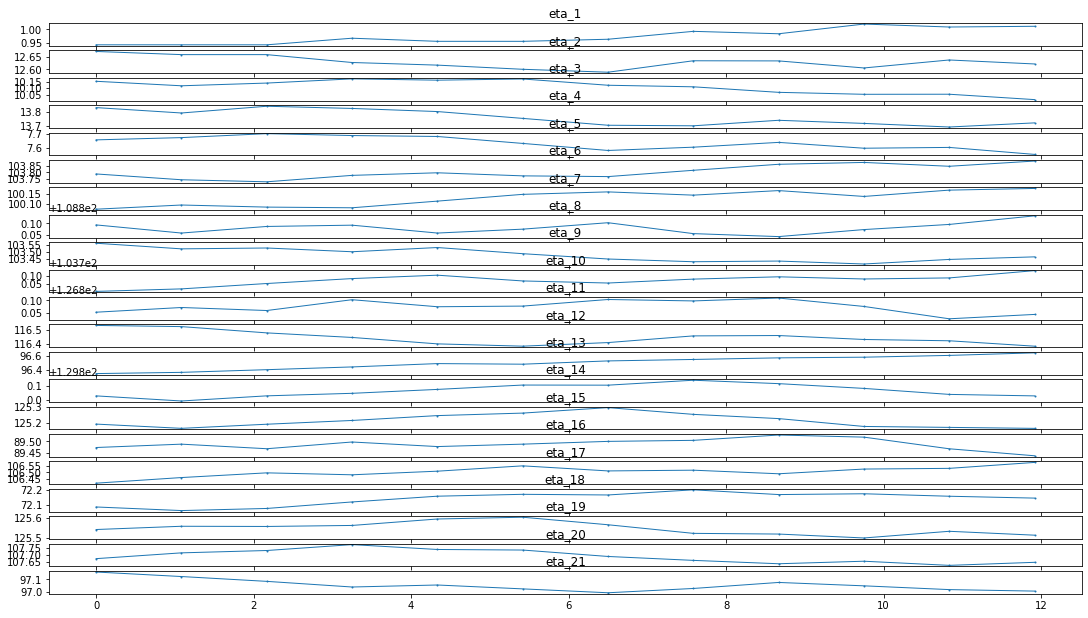

In [11]:
fig, axs = plt.subplots(np.shape(eta)[1], 1)
fig.set_size_inches(18.5, 10.5)

for j in range(N):
    idx = np.linspace(0,Nsamples,num=len(eta[:,j]))
    #print(len(idx))
    #plt.scatter(idx,eta[:,0])
    axs[j].plot(idx,eta[:,j], 'o-',linewidth=1, markersize=1)
    axs[j].set_title(f'eta_{j+1}')
    
#fig.savefig('test2png.png', dpi=100)
np.divide(acceptCountEtas,Nsamples)

Text(0.5, 1.0, 'observed dataset')

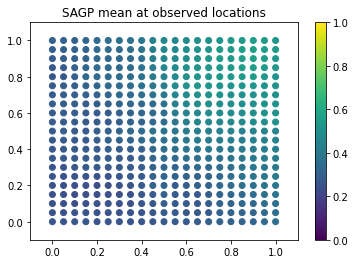

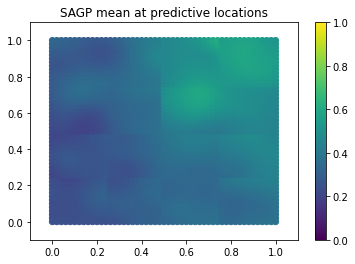

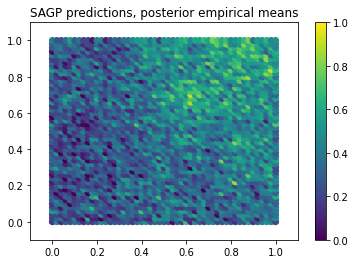

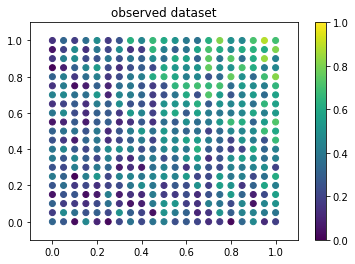

In [14]:
mu = np.delete(mu,-1,1)
mu_new = np.delete(mu_new,-1,1)
Yhat_new = np.delete(Yhat_new,-1,1)

keep_steps = minfo['Nmcmc']
keep_steps = int(keep_steps)

SAGP_mu=np.mean(mu[:,-keep_steps:],axis=1)
SAGP_mu_new=np.mean(mu_new[:,-keep_steps:],axis=1)
SAGP_Yhat=np.mean(Yhat_new[:,-keep_steps:],axis=1)

plt.figure(0)
plt.scatter(X[:,0],X[:,1], c=SAGP_mu, cmap='viridis',vmin=0,vmax=1)
plt.xlim(xmax = 1.1, xmin = -0.1)
plt.ylim(ymax = 1.1, ymin = -0.1)
plt.colorbar()
plt.title('SAGP mean at observed locations')

plt.figure(1)
plt.scatter(Xnew[:,0],Xnew[:,1], c=SAGP_mu_new, cmap='viridis',vmin=0,vmax=1)
plt.xlim(xmax = 1.1, xmin = -0.1)
plt.ylim(ymax = 1.1, ymin = -0.1)
plt.colorbar()
plt.title('SAGP mean at predictive locations')


plt.figure(2)
plt.scatter(Xnew[:,0],Xnew[:,1], c=SAGP_Yhat,  cmap='viridis',vmin=0,vmax=1)
plt.xlim(xmax = 1.1, xmin = -0.1)
plt.ylim(ymax = 1.1, ymin = -0.1)
plt.colorbar()
plt.title('SAGP predictions, posterior empirical means')

plt.figure(3)
plt.scatter(X[:,0],X[:,1], c=Y*sdY+meanY, cmap='viridis',vmin=0,vmax=1)
plt.xlim(xmax = 1.1, xmin = -0.1)
plt.ylim(ymax = 1.1, ymin = -0.1)
plt.colorbar()
plt.title('observed dataset')
#print(SAGP_mu_new)
#print(SAGP_Yhat-Y)


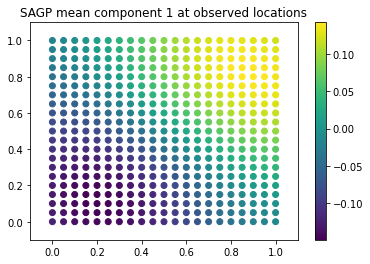

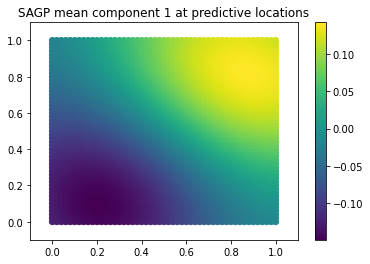

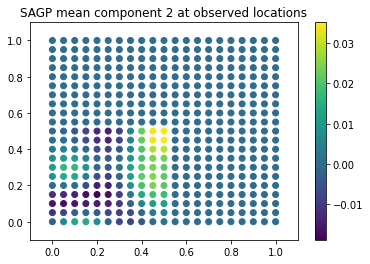

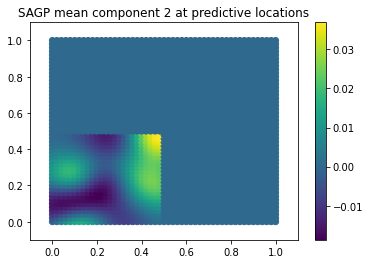

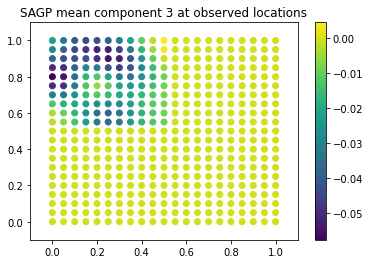

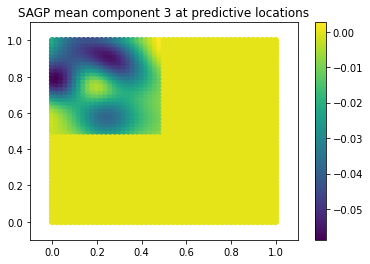

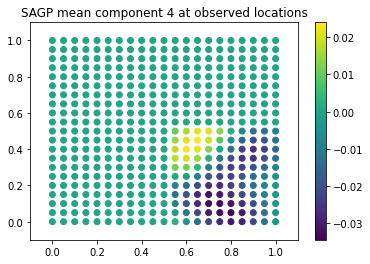

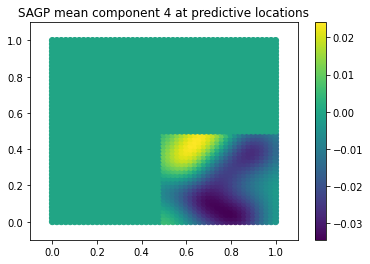

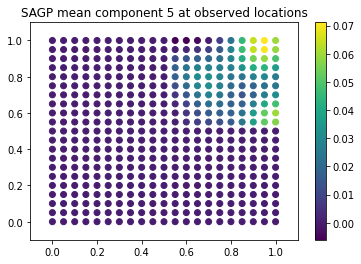

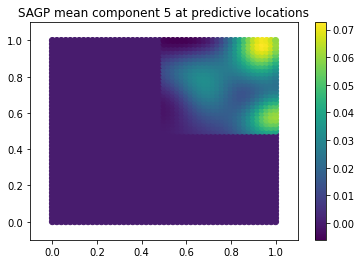

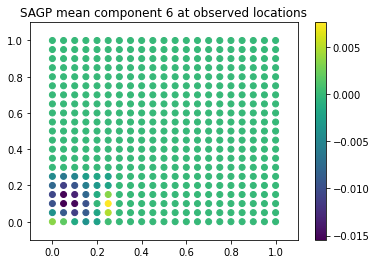

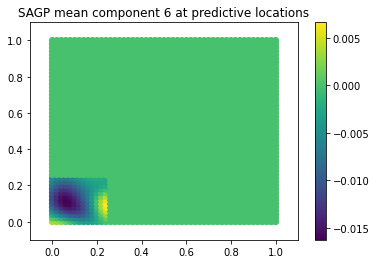

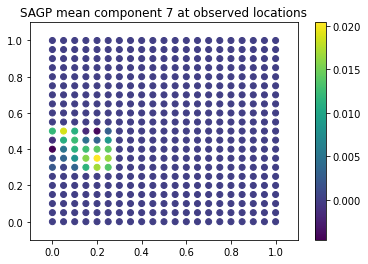

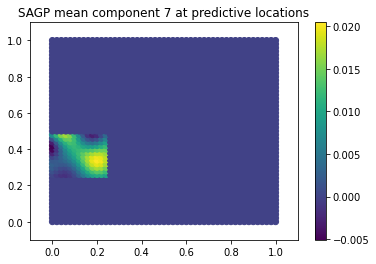

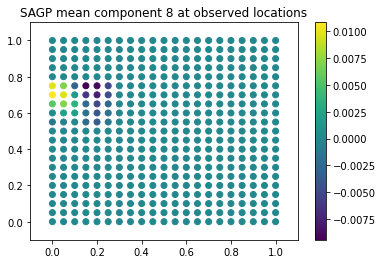

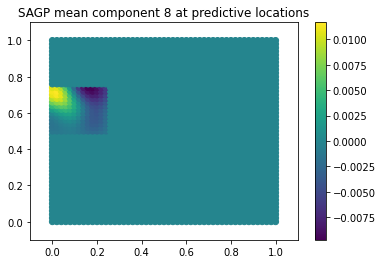

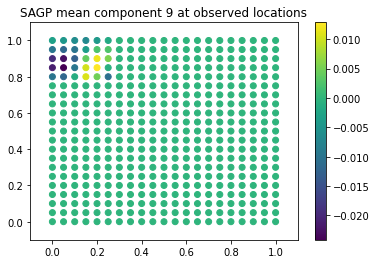

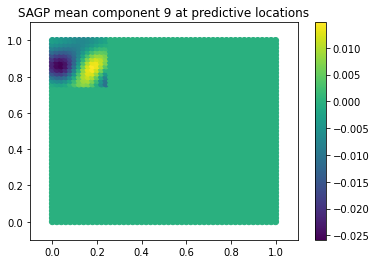

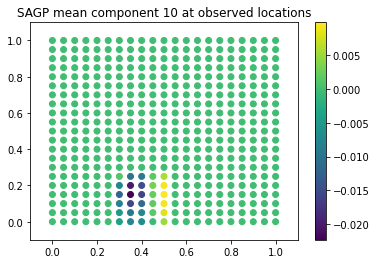

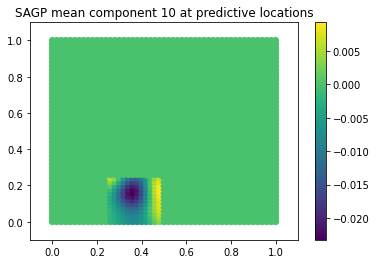

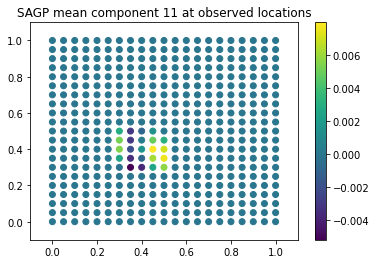

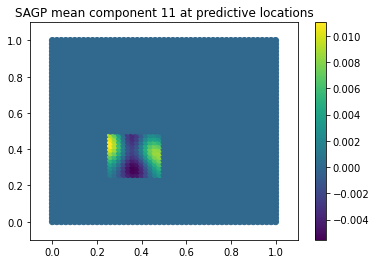

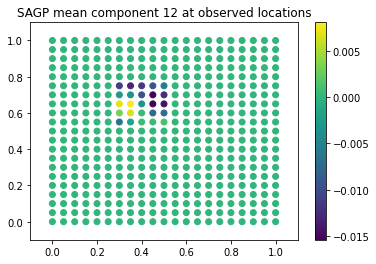

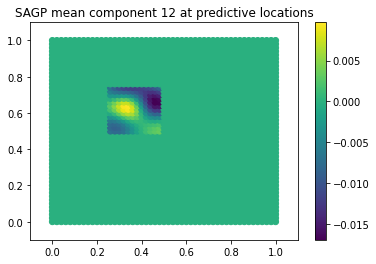

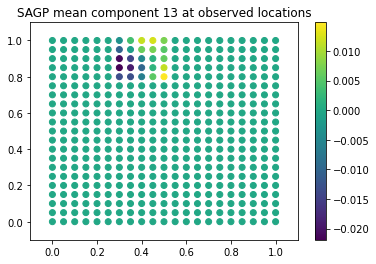

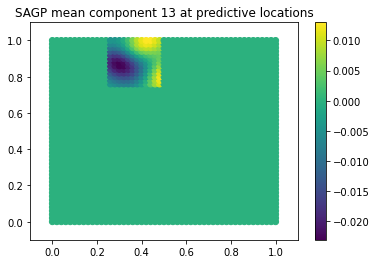

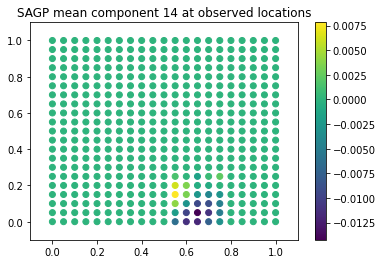

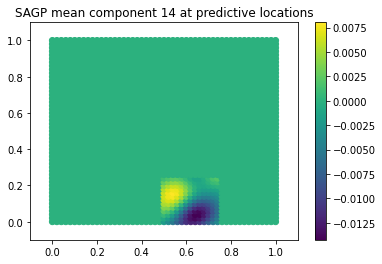

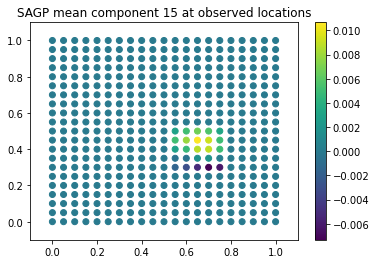

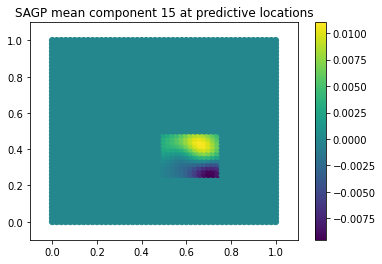

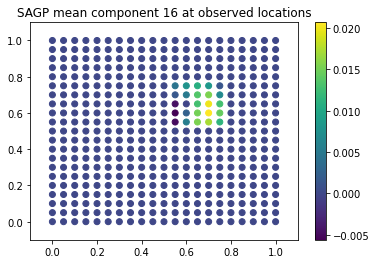

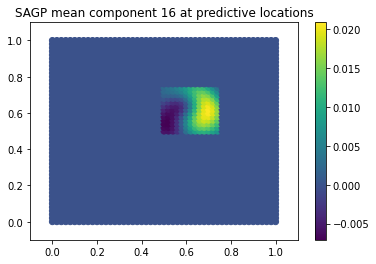

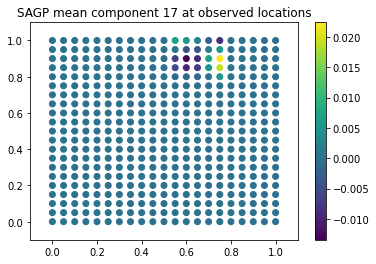

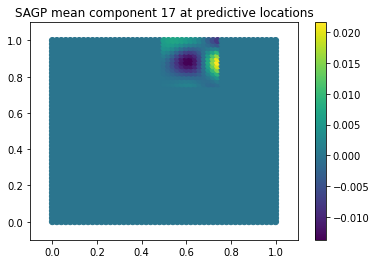

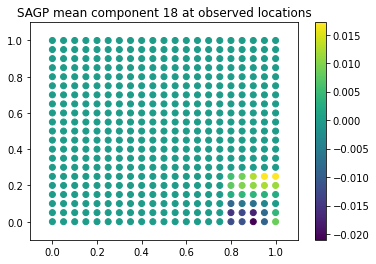

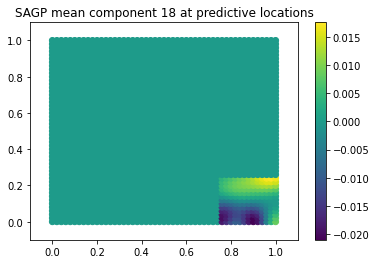

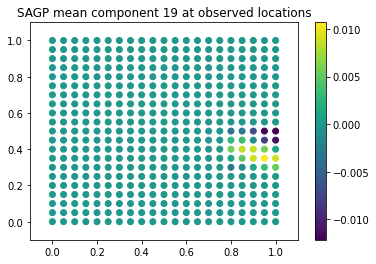

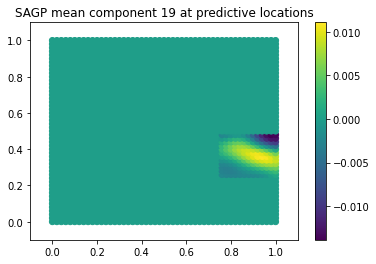

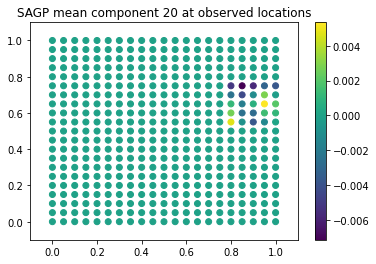

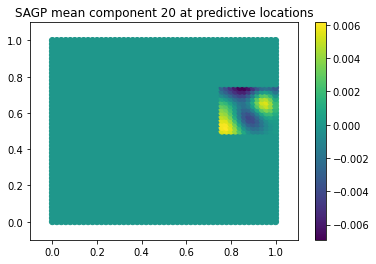

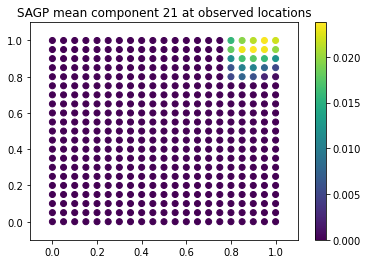

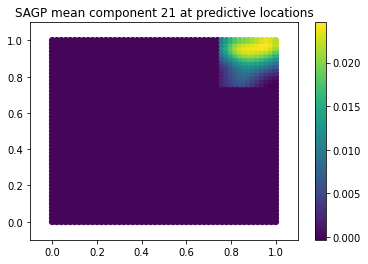

In [13]:
mu_component_sum=mu_component[Nmcmc-1]
mu_new_component_sum=mu_new_component[Nmcmc-1]
k=0
for i in range(Nmcmc-1,burnIn,-1):
    k=k+1
    mu_component_sum=mu_component_sum+mu_component[i]
    mu_new_component_sum=mu_new_component_sum+mu_new_component[i]

mu_component_sum=mu_component_sum/k
mu_new_component_sum=mu_new_component_sum/k

for j in layers[:,0]:
    plt.figure(2*j)
    plt.scatter(X[:,0],X[:,1], c=mu_component_sum[:,j-1], cmap='viridis')
    plt.xlim(xmax = 1.1, xmin = -0.1)
    plt.ylim(ymax = 1.1, ymin = -0.1)
    plt.colorbar()
    plt.title('SAGP mean component '+ str(j)+' at observed locations')
    
    plt.figure(2*j+1)
    plt.scatter(Xnew[:,0],Xnew[:,1], c=mu_new_component_sum[:,j-1], cmap='viridis')
    plt.xlim(xmax = 1.1, xmin = -0.1)
    plt.ylim(ymax = 1.1, ymin = -0.1)
    plt.colorbar()
    plt.title('SAGP mean component '+ str(j)+' at predictive locations')

